In [30]:
# import os
# import json
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

In [31]:
# def load_json_files_to_dataframe(directory):
#     all_data = []

#     for filename in os.listdir(directory):
#         if filename.endswith(".json"):
#             filepath = os.path.join(directory, filename)
#             with open(filepath, 'r') as file:
#                 data = json.load(file)
                
#                 # Extract common data
#                 row = {
#                     'd': data['d'],
#                     'n': data['n'],
#                     'p': data['p'],
#                     'final_train_loss': data['final_train_loss'],
#                     'final_test_loss': data['final_test_loss'],
#                     'train_loss_star': data.get('train_loss_star'),
#                     'test_loss_star': data.get('test_loss_star'),
#                     'target': data['target'],
#                     'eps': data['eps'],
#                     'eta': data['eta'],
#                     'T': data['T'],
#                     'C_clip': data['C_clip'],
#                     'C_time': data['C_time'],
#                     'train_losses': data['train_losses'],
#                     'test_losses': data['test_losses'],
#                     'clip_counts': data['clip_counts']
#                 }
#                 all_data.append(row)
    
#     # Create DataFrame
#     df = pd.DataFrame(all_data)
    
#     return df

In [1]:
# # Directory containing the JSON files
# directory = './synthetic/trial_monday_22_07_new'

# # Load data into DataFrame
# df = load_json_files_to_dataframe(directory)
# df

In [14]:
# # Example of how to filter and plot data
# def plot_losses(df, d, n, p, target, eps):
#     # Filter the DataFrame based on the fixed parameters
#     df_filtered = df[
#         (df['d'] == d) & 
#         (df['n'] == n) & 
#         (df['p'] == p) & 
#         (df['target'] == target) & 
#         (df['eps'] == eps)
#     ]

#     # Get unique values of C_clip and C_time
#     unique_C_clip = df_filtered['C_clip'].unique()
#     unique_C_time = df_filtered['C_time'].unique()
    
#     # Set the seaborn style and palette
#     sns.set(style='darkgrid')
#     new_palette = ['#c44e52', 'black']
#     sns.set_palette(new_palette)
    
#     # Create subplots for train losses
#     fig, axs = plt.subplots(len(unique_C_time), len(unique_C_clip), figsize=(5 * len(unique_C_clip), 5 * len(unique_C_time)), sharey=True)
    
#     for i, C_time in enumerate(unique_C_time):
#         for j, C_clip in enumerate(unique_C_clip):
#             ax = axs[i, j] if len(unique_C_time) > 1 else axs[j]
#             subset = df_filtered[(df_filtered['C_clip'] == C_clip) & (df_filtered['C_time'] == C_time)]
#             if not subset.empty:
#                 for index, row in subset.iterrows():
#                     T = row['T']
#                     epochs = range(len(row['train_losses']))  # Ensure x and y have the same length
#                     sns.lineplot(x=epochs, y=row['train_losses'], ax=ax, label=f'T={T}, η={row["eta"]}')
#             ax.set_title(f'C_clip = {C_clip}, C_time = {C_time}')
#             ax.set_xlabel('Epoch')
#             ax.set_ylabel('Train Loss')
#             ax.legend()
    
#     plt.tight_layout()
#     plt.show()

#     # Create subplots for test losses
#     fig, axs = plt.subplots(len(unique_C_time), len(unique_C_clip), figsize=(5 * len(unique_C_clip), 5 * len(unique_C_time)), sharey=True)
    
#     for i, C_time in enumerate(unique_C_time):
#         for j, C_clip in enumerate(unique_C_clip):
#             ax = axs[i, j] if len(unique_C_time) > 1 else axs[j]
#             subset = df_filtered[(df_filtered['C_clip'] == C_clip) & (df_filtered['C_time'] == C_time)]
#             if not subset.empty:
#                 for index, row in subset.iterrows():
#                     T = row['T']
#                     epochs = range(len(row['test_losses']))  # Ensure x and y have the same length
#                     sns.lineplot(x=epochs, y=row['test_losses'], ax=ax, label=f'T={T}, η={row["eta"]}')
#             ax.set_title(f'C_clip = {C_clip}, C_time = {C_time}')
#             ax.set_xlabel('Epoch')
#             ax.set_ylabel('Test Loss')
#             ax.legend()
    
#     plt.tight_layout()
#     plt.show()

In [15]:
# Example usage:
# plot_losses(df, d=200, n=20000, p=100000, target='linear', eps=4)

In [2]:
# df_filtered = df[
#         (df['d'] == 200) & 
#         (df['n'] == 20000) & 
#         (df['p'] == 100000) & 
#         (df['target'] == 'linear') & 
#         (df['eps'] == 4) &
#         (df['C_time'] == 2) &
#         (df['C_clip'] == 1)
#     ]

# for i, row in df_filtered.iterrows():
#     print(len(row['train_losses']))

In [16]:
# row['train_losses']

In [17]:
# def plot_losses(df, n, p, target, eps_values, d_values):
#     # Filter the DataFrame based on the fixed parameters
#     df_filtered = df[
#         (df['n'] == n) & 
#         (df['p'] == p) & 
#         (df['target'] == target) & 
#         (df['eps'].isin(eps_values)) &
#         (df['d'].isin(d_values))
#     ]

#     # Get unique values of C_clip and C_time
#     unique_C_clip = df_filtered['C_clip'].unique()
#     unique_C_time = df_filtered['C_time'].unique()
    
#     # Set the seaborn style and palette
#     sns.set(style='darkgrid')
#     new_palette = sns.color_palette("tab10", len(d_values))
#     sns.set_palette(new_palette)
    
#     # Create subplots for train losses
#     fig, axs = plt.subplots(len(unique_C_time), len(unique_C_clip), figsize=(5 * len(unique_C_clip), 5 * len(unique_C_time)), sharey=True)
    
#     for i, C_time in enumerate(unique_C_time):
#         for j, C_clip in enumerate(unique_C_clip):
#             ax = axs[i, j] if len(unique_C_time) > 1 else axs[j]
#             subset = df_filtered[(df_filtered['C_clip'] == C_clip) & (df_filtered['C_time'] == C_time)]
#             if not subset.empty:
#                 for index, row in subset.iterrows():
#                     T = row['T']
#                     epochs = range(len(row['train_losses']))  # Ensure x and y have the same length
#                     sns.lineplot(x=epochs, y=row['train_losses'], hue=row['d'], style=row['eps'], ax=ax)
#             ax.set_title(f'C_clip = {C_clip}, C_time = {C_time}')
#             ax.set_xlabel('Epoch')
#             ax.set_ylabel('Train Loss')
    
#     handles, labels = ax.get_legend_handles_labels()
#     fig.legend(handles, labels, loc='upper right')
#     plt.tight_layout()
#     plt.show()

#     # Create subplots for test losses
#     fig, axs = plt.subplots(len(unique_C_time), len(unique_C_clip), figsize=(5 * len(unique_C_clip), 5 * len(unique_C_time)), sharey=True)
    
#     for i, C_time in enumerate(unique_C_time):
#         for j, C_clip in enumerate(unique_C_clip):
#             ax = axs[i, j] if len(unique_C_time) > 1 else axs[j]
#             subset = df_filtered[(df_filtered['C_clip'] == C_clip) & (df_filtered['C_time'] == C_time)]
#             if not subset.empty:
#                 for index, row in subset.iterrows():
#                     T = row['T']
#                     epochs = range(len(row['test_losses']))  # Ensure x and y have the same length
#                     sns.lineplot(x=epochs, y=row['test_losses'], hue=row['d'], style=row['eps'], ax=ax)
#             ax.set_title(f'C_clip = {C_clip}, C_time = {C_time}')
#             ax.set_xlabel('Epoch')
#             ax.set_ylabel('Test Loss')
    
#     handles, labels = ax.get_legend_handles_labels()
#     fig.legend(handles, labels, loc='upper right')
#     plt.tight_layout()
#     plt.show()


In [18]:
# # Example usage:
# directory = './synthetic/trial_sunday_21_07'

# # Load data into DataFrame
# df = load_json_files_to_dataframe(directory)
# df

In [19]:
# plot_losses(df, n=20000, p=100000, target='sign', eps_values=[4, 8], d_values=[200, 400])

In [3]:
import os
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [63]:
def load_json_files_to_dataframe(directory):
    all_data = []

    for filename in os.listdir(directory):
        if filename.endswith(".json"):
            filepath = os.path.join(directory, filename)
            with open(filepath, 'r') as file:
                data = json.load(file)
                row = {
                    'd': data['d'],
                    'n': data['n'],
                    'p': data['p'],
                    'final_train_loss': data['final_train_loss'],
                    'final_test_loss': data['final_test_loss'],
                    'final_train_loss_star': data['final_train_loss_star'], 
                    'final_test_loss_star': data['final_test_loss_star'],
                    'train_losses': data['train_losses'],
                    'test_losses': data['test_losses'],
                    'grad_norms': data['grad_norms'],
                    'train_losses_star': data['train_losses_star'],
                    'test_losses_star': data['test_losses_star'],
                    'train_loss_pseudo': data['train_loss_pseudo'],
                    'test_loss_pseudo': data['test_loss_pseudo'],
                    'target': data['target'],
                    'eps': data['eps'],
                    'eta': data['eta'],
                    'T': data['T'],
                    'C_clip': data['C_clip'],
                    'C_time': data['C_time']
                }
                all_data.append(row)
    
    # Create DataFrame
    df = pd.DataFrame(all_data)
    
    return df

In [64]:
# # Directory containing the JSON files
# directory = './synthetic/trial_monday_22_07_tanh'

# # Load data into DataFrame
# df = load_json_files_to_dataframe(directory)
# # df

In [65]:
# def plot_losses(df, n, p, target, eps_values, d_values):
#     # Filter the DataFrame based on the fixed parameters
#     df_filtered = df[
#         (df['n'] == n) & 
#         (df['p'] == p) & 
#         (df['target'] == target) & 
#         (df['eps'].isin(eps_values)) &
#         (df['d'].isin(d_values))
#     ]

#     # Get unique values of C_clip and C_time
#     unique_C_clip = df_filtered['C_clip'].unique()
#     unique_C_time = df_filtered['C_time'].unique()
    
#     # Set the seaborn style and palette
#     sns.set(style='darkgrid')
#     new_palette = ['#c44e52', 'black']
#     sns.set_palette(new_palette)
    
#     # Create subplots for train losses
#     fig, axs = plt.subplots(len(unique_C_time), len(unique_C_clip), figsize=(5 * len(unique_C_clip), 5 * len(unique_C_time)), sharey=True)
    
#     for i, C_time in enumerate(unique_C_time):
#         for j, C_clip in enumerate(unique_C_clip):
#             ax = axs[i, j] if len(unique_C_time) > 1 else axs[j]
#             subset = df_filtered[(df_filtered['C_clip'] == C_clip) & (df_filtered['C_time'] == C_time)]
#             if not subset.empty:
#                 if i == 0 and j == 0:
#                     print(subset)

#                 for index, row in subset.iterrows():
#                     if True:
#                         epochs = range(len(row['train_losses']))  # Ensure x and y have the same length
#                         sns.lineplot(data=subset, x=epochs, y=row['train_losses'], hue=row['d'], style=row['eps'], ax=ax)
#                 if 'train_loss_star' in row:
#                     ax.axhline(y=row['train_loss_star'], color='blue', linestyle='--', label='Train Loss Star')
#             ax.set_title(f'C_clip = {C_clip}, C_time = {C_time}')
#             ax.set_xlabel('Epoch')
#             ax.set_ylabel('Train Loss')
    
#     handles, labels = ax.get_legend_handles_labels()
#     fig.legend(handles, labels, loc='upper right')
#     plt.tight_layout()
#     plt.show()

#     # Create subplots for test losses
#     fig, axs = plt.subplots(len(unique_C_time), len(unique_C_clip), figsize=(5 * len(unique_C_clip), 5 * len(unique_C_time)), sharey=True)
    
#     for i, C_time in enumerate(unique_C_time):
#         for j, C_clip in enumerate(unique_C_clip):
#             ax = axs[i, j] if len(unique_C_time) > 1 else axs[j]
#             subset = df_filtered[(df_filtered['C_clip'] == C_clip) & (df_filtered['C_time'] == C_time)]
#             if not subset.empty:
#                 for index, row in subset.iterrows():
#                     if True:
#                         epochs = range(len(row['test_losses']))  # Ensure x and y have the same length
#                         sns.lineplot(x=epochs, y=row['test_losses'], hue=row['d'], style=row['eps'], ax=ax)
#                 if 'test_loss_star' in row:
#                     ax.axhline(y=row['test_loss_star'], color='blue', linestyle='--', label='Test Loss Star')
#             ax.set_title(f'C_clip = {C_clip}, C_time = {C_time}')
#             ax.set_xlabel('Epoch')
#             ax.set_ylabel('Test Loss')
    
#     handles, labels = ax.get_legend_handles_labels()
#     fig.legend(handles, labels, loc='upper right')
#     plt.tight_layout()
#     plt.show()

In [66]:
# def plot_losses(df, n, p, target, eps_values, d_values):
#     # Filter the DataFrame based on the fixed parameters
#     df_filtered = df[
#         (df['n'] == n) & 
#         (df['p'] == p) & 
#         (df['target'] == target) & 
#         (df['eps'].isin(eps_values)) &
#         (df['d'].isin(d_values))
#     ]

#     # Get unique values of C_clip and C_time
#     unique_C_clip = sorted(df_filtered['C_clip'].unique())
#     unique_C_time = sorted(df_filtered['C_time'].unique())
    
#     # Set the seaborn style and palette
#     sns.set(style='darkgrid')
#     new_palette = ['#c44e52', 'black']
#     sns.set_palette(new_palette)
    
#     # Create subplots for train losses
#     fig, axs = plt.subplots(len(unique_C_time), len(unique_C_clip), figsize=(5 * len(unique_C_clip), 5 * len(unique_C_time)), sharey=True)
    
#     for i, C_time in enumerate(unique_C_time):
#         for j, C_clip in enumerate(unique_C_clip):
#             ax = axs[i, j] if len(unique_C_time) > 1 else axs[j]
#             subset = df_filtered[(df_filtered['C_clip'] == C_clip) & (df_filtered['C_time'] == C_time)]
#             if not subset.empty:
#                 subset_expanded = pd.DataFrame()
#                 for index, row in subset.iterrows():
#                     epochs = range(len(row['train_losses']))
#                     temp_df = pd.DataFrame({
#                         'epoch': epochs,
#                         'train_loss': row['train_losses'],
#                         'd': row['d'],
#                         'eps': row['eps']
#                     })
#                     subset_expanded = pd.concat([subset_expanded, temp_df], ignore_index=True)
                
#                 sns.lineplot(data=subset_expanded, x='epoch', y='train_loss', hue='d', style='eps', ax=ax)
                
#                 if 'train_loss_star' in row:
#                     ax.axhline(y=row['train_loss_star'], color='blue', linestyle='--', label='Train Loss Star')
#             ax.set_title(f'C_clip = {C_clip}, C_time = {C_time}')
#             ax.set_xlabel('Epoch')
#             ax.set_ylabel('Train Loss')
#             ax.set_ylim(-0.1, 3)  # Set y-axis limits
    
#     handles, labels = ax.get_legend_handles_labels()
#     fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)
#     plt.tight_layout()
#     plt.show()

#     # Create subplots for test losses
#     fig, axs = plt.subplots(len(unique_C_time), len(unique_C_clip), figsize=(5 * len(unique_C_clip), 5 * len(unique_C_time)), sharey=True)
    
#     for i, C_time in enumerate(unique_C_time):
#         for j, C_clip in enumerate(unique_C_clip):
#             ax = axs[i, j] if len(unique_C_time) > 1 else axs[j]
#             subset = df_filtered[(df_filtered['C_clip'] == C_clip) & (df_filtered['C_time'] == C_time)]
#             if not subset.empty:
#                 subset_expanded = pd.DataFrame()
#                 for index, row in subset.iterrows():
#                     epochs = range(len(row['test_losses']))
#                     temp_df = pd.DataFrame({
#                         'epoch': epochs,
#                         'test_loss': row['test_losses'],
#                         'd': row['d'],
#                         'eps': row['eps']
#                     })
#                     subset_expanded = pd.concat([subset_expanded, temp_df], ignore_index=True)
                
#                 sns.lineplot(data=subset_expanded, x='epoch', y='test_loss', hue='d', style='eps', ax=ax)
                
#                 if 'test_loss_star' in row:
#                     ax.axhline(y=row['test_loss_star'], color='blue', linestyle='--', label='Test Loss Star')
#             ax.set_title(f'C_clip = {C_clip}, C_time = {C_time}')
#             ax.set_xlabel('Epoch')
#             ax.set_ylabel('Test Loss')
#             ax.set_ylim(-0.1, 3)  # Set y-axis limits
    
#     handles, labels = ax.get_legend_handles_labels()
#     fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)
#     plt.tight_layout()
#     plt.show()

In [67]:
# df_C = df.loc[df['C_clip'] <= 1]

# plot_losses(df, n=10000, p=100000, target='sign', eps_values=[2, 4, 8], d_values=[100])

In [68]:
# def plot_norms(df, n, p, target, eps_values, d_values):
#     # Filter the DataFrame based on the fixed parameters
#     df_filtered = df[
#         (df['n'] == n) & 
#         (df['p'] == p) & 
#         (df['target'] == target) & 
#         (df['eps'].isin(eps_values)) &
#         (df['d'].isin(d_values))
#     ]

#     # Get unique values of C_clip and C_time
#     unique_C_clip = df_filtered['C_clip'].unique()
#     unique_C_time = df_filtered['C_time'].unique()
    
#     # Set the seaborn style and palette
#     sns.set(style='darkgrid')
#     new_palette = ['#c44e52', 'black']
#     sns.set_palette(new_palette)
    
#     # Create subplots for train losses
#     fig, axs = plt.subplots(len(unique_C_time), len(unique_C_clip), figsize=(5 * len(unique_C_clip), 5 * len(unique_C_time)), sharey=True)
    
#     for i, C_time in enumerate(unique_C_time):
#         for j, C_clip in enumerate(unique_C_clip):
#             ax = axs[i, j] if len(unique_C_time) > 1 else axs[j]
#             subset = df_filtered[(df_filtered['C_clip'] == C_clip) & (df_filtered['C_time'] == C_time)]
#             if not subset.empty:
#                 subset_expanded = pd.DataFrame()
#                 for index, row in subset.iterrows():
#                     epochs = range(len(row['grad_norms']))
#                     temp_df = pd.DataFrame({
#                         'epoch': epochs,
#                         'grad_norms': row['grad_norms'],
#                         'd': row['d'],
#                         'eps': row['eps']
#                     })
#                     subset_expanded = pd.concat([subset_expanded, temp_df], ignore_index=True)
                
#                 sns.lineplot(data=subset_expanded, x='epoch', y='grad_norms', hue='d', style='eps', ax=ax)
  
#             ax.set_title(f'C_clip = {C_clip}, C_time = {C_time}')
#             ax.set_xlabel('Epoch')
#             ax.set_ylabel('Norms')
    
#     handles, labels = ax.get_legend_handles_labels()
#     fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)
#     plt.tight_layout()
#     plt.show()

In [69]:
# df_C = df.loc[df['C_clip'] <= 1]

# plot_norms(df_C, n=10000, p=100000, target='sign', eps_values=[0.5, 2], d_values=[100, 200])

In [70]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def plot_test_losses(df, n, p, target, eps_values):
    # Filter the DataFrame based on the fixed parameters and d=100
    df_filtered = df[
        (df['n'] == n) & 
        (df['p'] == p) & 
        (df['target'] == target) & 
        (df['eps'].isin(eps_values))
    ]

    # Get unique values of C_clip and C_time and sort them
    unique_C_clip = sorted(df_filtered['C_clip'].unique())
    unique_C_time = sorted(df_filtered['C_time'].unique(), reverse=True)
    
    # Set the seaborn style and define a fixed color palette for eps values
    sns.set(style='darkgrid')
    # viridis_colors = sns.color_palette('viridis', n_colors=20)  # Get colors from viridis palette
    my_colors = [[0.93, 0.82, 0.80],
        [0.66, 0.40, 0.56],
        [0.18, 0.12, 0.24]]
    eps_palette = dict(zip(sorted(eps_values), my_colors))  # Map eps values to viridis colors


    # Create subplots for test losses
    fig, axs = plt.subplots(len(unique_C_time), len(unique_C_clip), figsize=(4 * len(unique_C_clip), 2.8 * len(unique_C_time)), sharey=True)

    for i, C_time in enumerate(unique_C_time):
        for j, C_clip in enumerate(unique_C_clip):
            if i == 1 and j == 1:
                subset = df_filtered[(df_filtered['C_clip'] == C_clip) & (df_filtered['C_time'] == C_time)]
                mean_test_loss_star = subset['test_loss_pseudo'].mean()
                std_test_loss_star = subset['test_loss_pseudo'].std()
    
    for i, C_time in enumerate(unique_C_time):
        for j, C_clip in enumerate(unique_C_clip):
            ax = axs[i, j] if len(unique_C_time) > 1 else axs[j]
            subset = df_filtered[(df_filtered['C_clip'] == C_clip) & (df_filtered['C_time'] == C_time)]
            if not subset.empty:
                for eps in eps_values:
                    subset_eps = subset[subset['eps'] == eps]
                    if not subset_eps.empty:
                        subset_expanded = pd.DataFrame()
                        for index, row in subset_eps.iterrows():
                            epochs = range(len(row['test_losses']))
                            temp_df = pd.DataFrame({
                                'epoch': epochs,
                                'test_loss': row['test_losses']
                            })
                            subset_expanded = pd.concat([subset_expanded, temp_df], ignore_index=True)
                        
                        # Plot the line manually with a fixed color from the palette
                        sns.lineplot(data=subset_expanded, x='epoch', y='test_loss', ax=ax, color=eps_palette[eps], label=rf'$\varepsilon = {eps}$')

                if 'test_loss_pseudo' in subset.columns:
                    # mean_test_loss_star = subset['test_loss_pseudo'].mean()
                    # std_test_loss_star = subset['test_loss_pseudo'].std()
                    ax.axhline(y=mean_test_loss_star, color='blue', linestyle='--', label=r'$\theta^*$')
                    ax.fill_between([0, max(epochs)], 
                                    mean_test_loss_star - std_test_loss_star, 
                                    mean_test_loss_star + std_test_loss_star, 
                                    color='blue', alpha=0.2)
                    ax.set_xlim(0, max(epochs))
            
            p = 'p'
            title_text = ax.set_title(rf'$C_{{\text{{clip}}}} \, / \sqrt{{p}} = {C_clip}  \quad  C_{{\text{{time}}}} = {C_time}$', fontsize=12, loc='left', pad=-20)
            title_text.set_position((0.38, 0.02))

            if i == 2:
                ax.set_xlabel('Epoch')
            else:
                ax.set_xlabel('')
            
            # ax.tick_params(axis='x', direction='in', pad=-20)
            # ax.set_xlabel('Epoch', labelpad=-50)  # Negative values bring the label closer

            # tick_labels = ax.get_xticklabels()
            # print(tick_labels)
            # tick_labels = tick_labels[1:]
            # print(tick_labels)

            ax.set_ylabel('Test loss')
            ax.set_ylim(0.34, 1.21)  # Set y-axis limits

            # Only add the legend to the first subplot (top left)
            if i == 0 and j == 0:
                ax.legend(loc='upper left')
            else:
                ax.get_legend().remove()  # Remove the legend from other subplots

    plt.tight_layout()

    # Save the figure as PDF
    fig.savefig('RF_original.pdf', format='pdf')
    
    plt.show()


In [71]:
# directory = './synthetic/trial_wed_25_07'
directory = './synthetic/03_09_original'

# Load data into DataFrame
df = load_json_files_to_dataframe(directory)
# df

In [72]:
# custom_color = [0.93, 0.82, 0.80]
# [0.66, 0.40, 0.56]
# [0.18, 0.12, 0.24]

In [73]:
import pandas as pd

def create_df_light(df):
    # Function to reduce the list size by picking one value every 100 entries
    def reduce_list(lst):
        return lst[::50]  # Take one value every 100

    # Apply the reduction to the relevant columns
    df_light = df.copy()
    df_light['train_losses'] = df_light['train_losses'].apply(reduce_list)
    df_light['test_losses'] = df_light['test_losses'].apply(reduce_list)
    df_light['train_losses_star'] = df_light['train_losses_star'].apply(reduce_list)
    df_light['test_losses_star'] = df_light['test_losses_star'].apply(reduce_list)
    
    return df_light


df_light = create_df_light(df)


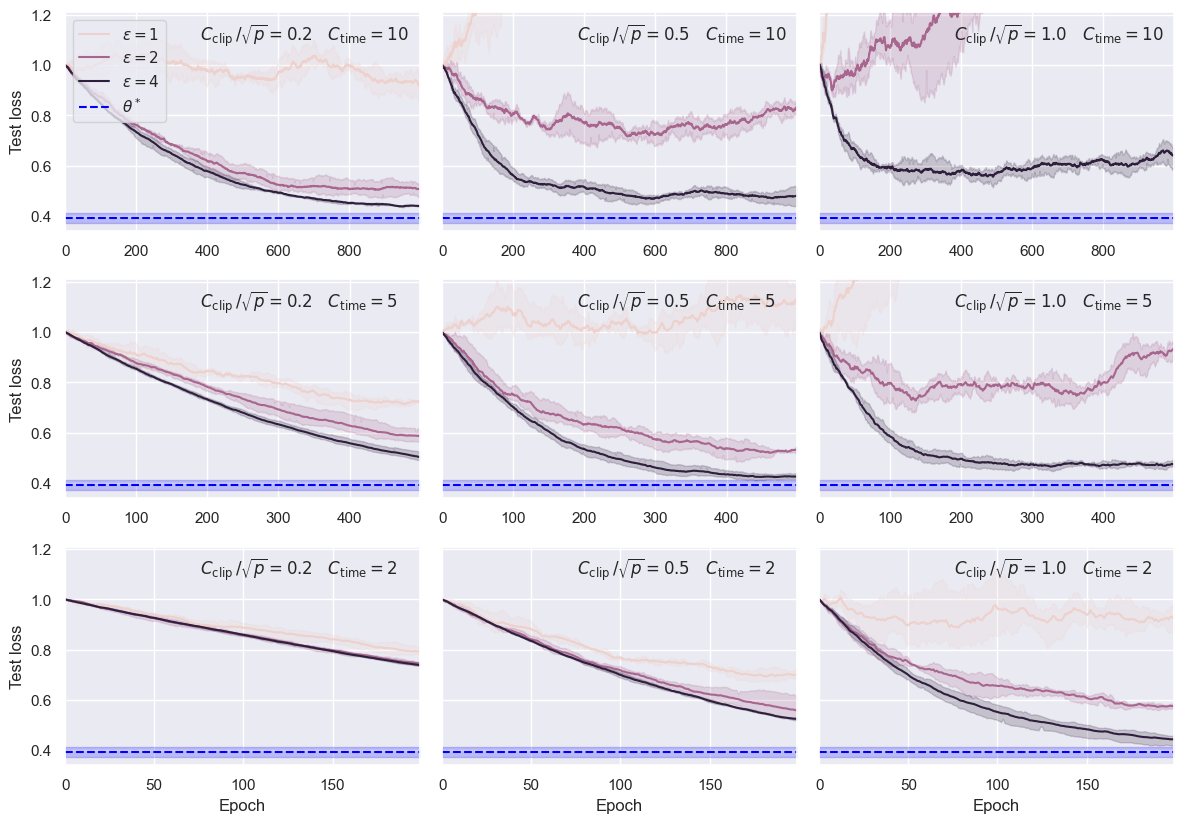

In [74]:
# df_100 = df.loc[df['d'] == 50]
# df_100 = df.loc[df['eps'] <= 5]
# plot_test_losses(df, n=10000, p=100000, target='sign', eps_values=[1, 2, 5, 10])
plot_test_losses(df, n=2000, p=40000, target='sign', eps_values=[1, 2, 4])

In [245]:
# def plot_losses_star(df, n, p, target, eps_values, plot_type='test'):
#     """
#     Function to plot either test_losses_star or train_losses_star based on plot_type.
    
#     Parameters:
#     - df: DataFrame containing the data
#     - n, p, target: Fixed parameters to filter the DataFrame
#     - eps_values: List of epsilon values to filter the DataFrame
#     - plot_type: 'test' to plot test_losses_star, 'train' to plot train_losses_star (default is 'test')
#     """
#     # Filter the DataFrame based on the fixed parameters and d=100
#     df_filtered = df[
#         (df['n'] == n) & 
#         (df['p'] == p) & 
#         (df['target'] == target) & 
#         (df['eps'].isin(eps_values))
#     ]

#     # Determine which column to plot
#     if plot_type == 'test':
#         loss_column = 'test_losses_star'
#         ylabel = 'Test Loss Star'
#     elif plot_type == 'train':
#         loss_column = 'train_losses_star'
#         ylabel = 'Train Loss Star'
#     else:
#         raise ValueError("plot_type must be either 'test' or 'train'")

#     # Get unique values of C_clip and C_time and sort them
#     unique_C_clip = sorted(df_filtered['C_clip'].unique())
#     unique_C_time = sorted(df_filtered['C_time'].unique())
    
#     # Set the seaborn style and palette
#     sns.set(style='darkgrid')
#     sns.set_palette(['#c44e52', 'black'])

#     # Create subplots for the chosen losses
#     fig, axs = plt.subplots(len(unique_C_time), len(unique_C_clip), figsize=(4 * len(unique_C_clip), 4 * len(unique_C_time)), sharey=True)
    
#     for i, C_time in enumerate(unique_C_time):
#         for j, C_clip in enumerate(unique_C_clip):
#             ax = axs[i, j] if len(unique_C_time) > 1 else axs[j]
#             subset = df_filtered[(df_filtered['C_clip'] == C_clip) & (df_filtered['C_time'] == C_time)]
#             if not subset.empty:
#                 subset_expanded = pd.DataFrame()
#                 for index, row in subset.iterrows():
#                     epochs = range(len(row[loss_column]))
#                     temp_df = pd.DataFrame({
#                         'epoch': epochs,
#                         loss_column: row[loss_column],
#                         'eps': row['eps']
#                     })
#                     subset_expanded = pd.concat([subset_expanded, temp_df], ignore_index=True)
                
#                 sns.lineplot(data=subset_expanded, x='epoch', y=loss_column, hue='eps', ax=ax)
                
#                 if 'test_loss_pseudo' in subset.columns:
#                     mean_test_loss_star = subset['test_loss_pseudo'].mean()
#                     std_test_loss_star = subset['test_loss_pseudo'].std()
#                     ax.axhline(y=mean_test_loss_star, color='blue', linestyle='--', label='Mean Test Loss Pseudo')
#                     ax.fill_between([0, max(epochs)], 
#                                     mean_test_loss_star - std_test_loss_star, 
#                                     mean_test_loss_star + std_test_loss_star, 
#                                     color='blue', alpha=0.2)
            
#             ax.set_title(rf'$C_{{\text{{clip}}}} = {C_clip}, C_{{\text{{time}}}} = {C_time}$', fontsize=12)
#             ax.set_xlabel('Epoch')
#             ax.set_ylabel(ylabel)
#             ax.set_ylim(-0.1, 1.5)  # Set y-axis limits

#             # Only add the legend to the first subplot (top left)
#             if i == 0 and j == 0:
#                 ax.legend(loc='upper left')
#             else:
#                 ax.get_legend().remove()  # Remove the legend from other subplots

#     plt.tight_layout()
#     plt.show()


In [52]:
# plot_losses_star(df_light, n=2000, p=20000, target='sign', eps_values=[1, 2, 4], plot_type='train')

# For the grid

In [53]:
import numpy as np

In [54]:
def load_parameters_to_dataframe(directory):
    all_data = []
    
    for filename in os.listdir(directory):
        if filename.startswith("parameters_") and filename.endswith(".txt"):
            filepath = os.path.join(directory, filename)
            with open(filepath, 'r') as f:
                for line in f:
                    values = line.strip().split('\t')
                    data = {
                        'd': int(values[0]),
                        'n': int(values[1]),
                        'p': int(values[2]),
                        'final_train_loss': float(values[3]),
                        'final_test_loss': float(values[4]),
                        'train_loss_star': float(values[5]),
                        'test_loss_star': float(values[6]),
                        'target': values[7],
                        'eps': float(values[8]),
                        'CT': float(values[9]),
                        'C': float(values[10])
                    }
                    all_data.append(data)
    
    df = pd.DataFrame(all_data)
    return df


# directory = './synthetic/trial_sun_28_07_grid_airport'

# # Load data into DataFrame
# df = load_parameters_to_dataframe(directory)

In [554]:
# def plot_heatmap_final_test_loss(df, d, n, p, eps):
#     # Filter the DataFrame based on the fixed parameters
#     df_filtered = df[
#         (df['d'] == d) & 
#         (df['n'] == n) & 
#         (df['p'] == p) & 
#         (df['eps'] == eps)
#     ]

#     # Compute the final test loss
#     df_filtered['final_test_loss'] = df_filtered['test_losses'].apply(lambda x: x[-1])
#     df_filtered['final_test_loss'] = df_filtered['final_test_loss'].apply(lambda x: min(x, 1.5))
#     df_filtered['log_final_test_loss'] = np.log10(df_filtered['final_test_loss'])

#     # Pivot the DataFrame to get C_time and C_clip on the axes
#     heatmap_data = df_filtered.pivot(index='C_time', columns='C_clip', values='log_final_test_loss')

#     # Plot the heatmap
#     plt.figure(figsize=(10, 8))
#     sns.heatmap(heatmap_data, annot=False, cmap="viridis")
#     plt.title(f'Log Final Test Loss Heatmap (d={d}, n={n}, p={p}, epsilon={eps})')
#     plt.xlabel('C_clip')
#     plt.ylabel('C_time')
#     plt.gca().invert_yaxis()  # Invert the y-axis
#     plt.show()

In [555]:
# plot_heatmap_final_test_loss(df, d=200, n=10000, p=100000, eps=1)

In [556]:
# import pandas as pd
# import os
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns

In [107]:
def load_parameters_to_dataframe(directory):
    all_data = []
    
    for filename in os.listdir(directory):
        if filename.startswith("parameters_") and filename.endswith(".txt"):
            filepath = os.path.join(directory, filename)
            with open(filepath, 'r') as f:
                for line in f:
                    values = line.strip().split('\t')
                    data = {
                        'd': int(values[0]),
                        'n': int(values[1]),
                        'p': int(values[2]),
                        # 'final_train_loss': float(values[3]),
                        'final_test_loss': float(values[3]),
                        # 'train_loss_star': float(values[5]),
                        # 'test_loss_star': float(values[6]),
                        'target': values[4],
                        'eps': float(values[5]),
                        'CT': float(values[6]),
                        'C': float(values[7])
                    }
                    all_data.append(data)
    
    df = pd.DataFrame(all_data)
    return df

### Old one

In [123]:
# directory = './synthetic/trial_sun_28_07_grid_airport'

# df = load_parameters_to_dataframe(directory)

In [124]:
# df

In [125]:
# def plot_heatmap_final_test_loss(df, d, n, p, eps):
#     # Filter the DataFrame based on the fixed parameters and create a copy
#     df_filtered = df[
#         (df['d'] == d) & 
#         (df['n'] == n) & 
#         (df['p'] == p) & 
#         (df['eps'] == eps)
#     ].copy()

#     # Compute the final test loss and apply the minimum function
#     df_filtered['final_test_loss_crop'] = df_filtered['final_test_loss'].apply(lambda x: min(x, 1.5))
#     df_filtered['log_final_test_loss'] = np.log10(df_filtered['final_test_loss_crop'])

#     # Pivot the DataFrame to get C_time and C_clip on the axes
#     heatmap_data = df_filtered.pivot(index='CT', columns='C', values='log_final_test_loss')

#     # Plot the heatmap
#     plt.figure(figsize=(10, 8))
#     sns.heatmap(heatmap_data, annot=False, cmap="viridis", cbar=True)
#     plt.title(f'Log Final Test Loss Heatmap (d={d}, n={n}, p={p}, epsilon={eps})')
#     plt.xlabel('C_clip')
#     plt.ylabel('C_time')
#     plt.gca().invert_yaxis()  # Invert the y-axis
#     plt.xticks([])  # Remove x-axis labels
#     plt.yticks([])  # Remove y-axis labels
#     plt.show()

In [126]:
# plot_heatmap_final_test_loss(df, d=100, n=2000, p=10000, eps=4)

In [127]:
# def plot_heatmap_final_test_loss_binning(df, d, n, p, eps):
#     # Filter the DataFrame based on the fixed parameters
#     df_filtered = df[
#         (df['d'] == d) & 
#         (df['n'] == n) & 
#         (df['p'] == p) & 
#         (df['eps'] == eps)
#     ].copy()

#     # Compute the final test loss and apply the minimum function
#     df_filtered['final_test_loss_crop'] = df_filtered['final_test_loss'].apply(lambda x: min(x, 1.5))
#     df_filtered['log_final_test_loss'] = np.log10(df_filtered['final_test_loss_crop'])

#     # Create log-spaced bins for C and CT based on their range in df_filtered
#     C_bins = np.logspace(np.log10(df_filtered['C'].min()), np.log10(df_filtered['C'].max()), 40)
#     CT_bins = np.logspace(np.log10(df_filtered['CT'].min()), np.log10(df_filtered['CT'].max()), 40)

#     # Bin the C and CT values
#     df_filtered['C_binned'] = pd.cut(df_filtered['C'], bins=C_bins, right=False, include_lowest=True)
#     df_filtered['CT_binned'] = pd.cut(df_filtered['CT'], bins=CT_bins, right=False, include_lowest=True)

#     # Pivot the DataFrame using pivot_table to handle the binned data
#     heatmap_data = df_filtered.pivot_table(index='CT_binned', columns='C_binned', values='log_final_test_loss', aggfunc='mean')

#     # Plot the heatmap
#     plt.figure(figsize=(12, 10))
#     sns.heatmap(heatmap_data, annot=False, cmap="viridis", cbar=True)
#     plt.title(f'Log Final Test Loss Heatmap (d={d}, n={n}, p={p}, epsilon={eps})')
#     plt.xlabel('C_clip Bins')
#     plt.ylabel('C_time Bins')
#     plt.gca().invert_yaxis()  # Invert the y-axis
#     plt.xticks([])  # Remove x-axis labels
#     plt.yticks([])  # Remove y-axis labels
#     plt.show()

In [128]:
# Example usage:
# plot_heatmap_final_test_loss_binning(df, d=100, n=2000, p=10000, eps=4)

### New one

In [108]:
# directory = './synthetic/06_08_grid_kohsamui'

directory = './synthetic/30_08_grid'

df = load_parameters_to_dataframe(directory)

In [109]:
df

,d,n,p,final_test_loss,target,eps,CT,C
0,100,2000,40000,0.967558,sign,1.0,0.03,3.79
1,100,2000,40000,0.942896,sign,1.0,0.05,3.79
2,100,2000,40000,0.938353,sign,1.0,0.08,3.79
3,100,2000,40000,0.921500,sign,1.0,0.14,3.79
4,100,2000,40000,0.928094,sign,1.0,0.22,3.79
...,...,...,...,...,...,...,...,...
1195,100,2000,40000,11593.550548,sign,1.0,45.49,8.86
1196,100,2000,40000,32346.891395,sign,1.0,73.86,8.86
1197,100,2000,40000,85416.028757,sign,1.0,119.94,8.86
1198,100,2000,40000,256657.217793,sign,1.0,194.75,8.86


In [131]:
# def plot_heatmap(df, d, n, p, eps, quantity='final_test_loss'):
#     # Filter the DataFrame based on the fixed parameters
#     df_filtered = df[
#         (df['d'] == d) & 
#         (df['n'] == n) & 
#         (df['p'] == p) & 
#         (df['eps'] == eps)
#     ]

#     # Group by 'C' and 'CT' and calculate the mean of the relevant columns
#     df_grouped = df_filtered.groupby(['C', 'CT']).agg({
#         'final_train_loss': 'mean',
#         'final_test_loss': 'mean',
#         'train_loss_star': 'mean',
#         'test_loss_star': 'mean'
#     }).reset_index()

#     # Validate the 'quantity' input and apply the minimum function
#     if quantity not in df_grouped.columns:
#         raise ValueError(f"Invalid quantity '{quantity}'. Must be one of 'final_train_loss', 'final_test_loss', 'train_loss_star', 'test_loss_star'.")
    
#     df_grouped[f'{quantity}_crop'] = df_grouped[quantity].apply(lambda x: min(x, 1.5))
#     df_grouped[f'log_{quantity}'] = np.log10(df_grouped[f'{quantity}_crop'])

#     # Pivot the DataFrame to get CT and C on the axes
#     heatmap_data = df_grouped.pivot(index='CT', columns='C', values=f'log_{quantity}')

#     # Check if the heatmap_data is empty
#     if heatmap_data.empty:
#         raise ValueError(f"No data available to plot for the given parameters: d={d}, n={n}, p={p}, eps={eps}, quantity={quantity}")

#     # Plot the heatmap
#     plt.figure(figsize=(10, 8))
#     sns.heatmap(heatmap_data, annot=False, cmap="viridis", cbar=True)
#     plt.title(f'Log {quantity.replace("_", " ").title()} Heatmap (d={d}, n={n}, p={p}, epsilon={eps})')
#     plt.xlabel('C_clip')
#     plt.ylabel('C_time')
#     plt.gca().invert_yaxis()  # Invert the y-axis
#     plt.xticks([])  # Remove x-axis labels
#     plt.yticks([])  # Remove y-axis labels
#     plt.show()

# # Example usage:
# plot_heatmap(df, d=50, n=4000, p=20000, eps=4, quantity='final_test_loss')

In [132]:
# directory1 = './synthetic/14_08_grid_crema'
# df1 = load_parameters_to_dataframe(directory1)

# directory2 = './synthetic/16_08_grid_crema'
# df2 = load_parameters_to_dataframe(directory2)

# df_combined = pd.concat([df1, df2], axis=0)

# directory = './synthetic/21_08_grid_vienna_sign'

# df = load_parameters_to_dataframe(directory)

In [162]:
def plot_heatmap(df, d, n, p, epsilons, value_cap=None):
    # Create a figure with 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(12, 4.2), gridspec_kw={'width_ratios': [1, 1, 1]}, constrained_layout=True)

    # Store the minimum and maximum values across all epsilon heatmaps for consistent color scaling
    vmin, vmax = np.inf, -np.inf
    
    # First pass: Calculate the global min and max for color scaling
    for eps in epsilons:
        df_filtered = df[
            (df['d'] == d) & 
            (df['n'] == n) & 
            (df['p'] == p) & 
            (df['eps'] == eps)
        ]

        df_grouped = df_filtered.groupby(['C', 'CT']).agg({
            'final_test_loss': 'mean'
        }).reset_index()

        # Apply the cap to limit excessively high values if specified
        if value_cap:
            df_grouped['final_test_loss'] = df_grouped['final_test_loss'].apply(lambda x: min(x, value_cap))

        # Pivot the DataFrame to get CT and C on the axes
        heatmap_data = df_grouped.pivot(index='CT', columns='C', values='final_test_loss')

        if heatmap_data.empty:
            raise ValueError(f"No data available to plot for the given parameters: d={d}, n={n}, p={p}, eps={eps}")

        # Update global min and max
        vmin = min(vmin, heatmap_data.min().min())
        vmax = max(vmax, heatmap_data.max().max())
    
    # Second pass: Plot each heatmap with consistent color scaling
    for ax, eps in zip(axes, epsilons):
        df_filtered = df[
            (df['d'] == d) & 
            (df['n'] == n) & 
            (df['p'] == p) & 
            (df['eps'] == eps)
        ]

        df_grouped = df_filtered.groupby(['C', 'CT']).agg({
            'final_test_loss': 'mean'
        }).reset_index()

        # Apply the cap to limit excessively high values if specified
        if value_cap:
            df_grouped['final_test_loss'] = df_grouped['final_test_loss'].apply(lambda x: min(x, value_cap))

        heatmap_data = df_grouped.pivot(index='CT', columns='C', values='final_test_loss')

        # Plot the heatmap without the color bar for each subplot, except for the last one (eps=4)
        if eps != 4:
            sns.heatmap(heatmap_data, ax=ax, annot=False, cmap="viridis", vmin=vmin, vmax=vmax, cbar=False)
        else:
            sns.heatmap(heatmap_data, ax=ax, annot=False, cmap="viridis", vmin=vmin, vmax=vmax)

        ax.set_title(rf'$\epsilon = {eps}$', fontsize=14)  # LaTeX formatted title
        ax.set_xlabel(r'$C_{\text{clip}} \,/ \sqrt{p}$', fontsize=12)  # LaTeX formatted x-axis

        # Customize tick labels for both axes
        x_ticks = np.arange(0, len(heatmap_data.columns), step=3)  # Set x-ticks every 3rd value
        y_ticks = np.arange(0, len(heatmap_data.index), step=3)    # Set y-ticks every 3rd value
        
        ax.set_xticks(x_ticks)
        ax.set_yticks(y_ticks)
        
        # Use two decimal digits for values smaller than 1, and integer otherwise
        ax.set_xticklabels([f'{heatmap_data.columns[i]:.2f}' if heatmap_data.columns[i] < 1 else f'{int(heatmap_data.columns[i])}' for i in x_ticks])
        ax.set_yticklabels([f'{heatmap_data.index[i]:.2f}' if heatmap_data.index[i] < 1 else f'{int(heatmap_data.index[i])}' for i in y_ticks])
        
        # Remove y-axis label and ticks from the second and third subplots
        if ax != axes[0]:
            ax.set_ylabel('')
            ax.set_yticklabels([])
        else:
            ax.set_ylabel(r'$C_{\text{time}}$', fontsize=12)  # LaTeX formatted y-axis

        ax.plot([0, len(heatmap_data.columns)], [len(heatmap_data.index), 0], 'r--', linewidth=2)
        ax.text(13, 1, r'$T \propto C_{clip}^{-1}$', color='red', fontsize=10)
        
        ax.invert_yaxis()

    # Modify the color bar for the last plot (eps=4)
    cbar = axes[-1].collections[0].colorbar
    ticks = cbar.get_ticks()

    # Modify the highest tick to show "> value_cap"
    ticks = np.append(ticks[:-1], value_cap)  # Retain previous ticks but modify the last one
    cbar.set_ticks(ticks)
    cbar.set_ticklabels([f"{tick:.1f}" if tick < value_cap else f"> {value_cap}" for tick in ticks])

    # Add vertical label to the colorbar
    cbar.set_label('Test loss', rotation=270, labelpad=15, fontsize=12)

    # Save the plot
    fig.savefig('RF_grid_plot.pdf', format='pdf')

    plt.show()


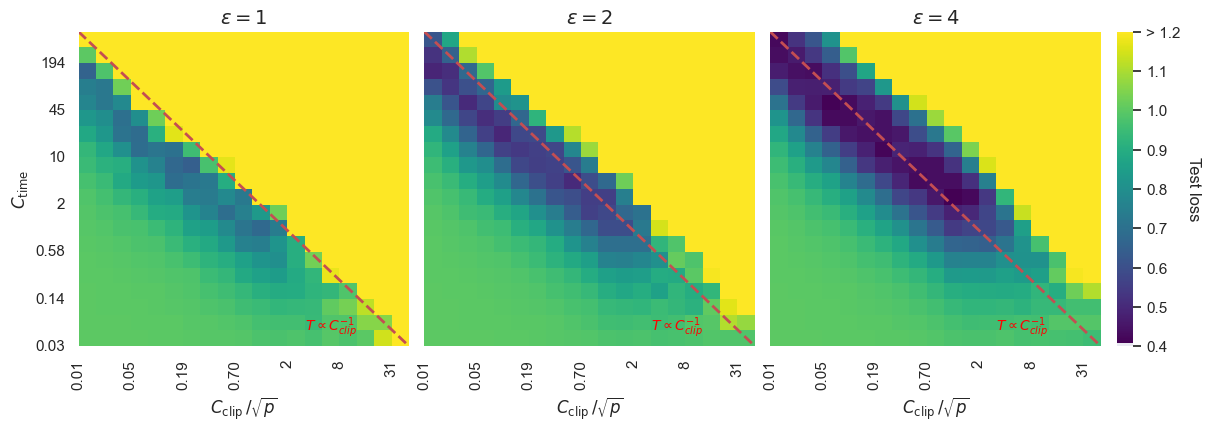

In [163]:
# Example usage:
plot_heatmap(df, d=100, n=2000, p=40000, epsilons=[1, 2, 4], value_cap=1.2)

In [179]:
# Example usage:
# plot_heatmap(df_combined, d=50, n=4000, p=20000, epsilons=[1, 2, 4], quantity='final_test_loss')

# grid for NN

In [2]:
def load_parameters_to_dataframe_NN(directory):
    all_data = []
    
    for filename in os.listdir(directory):
        if filename.startswith("parameters_") and filename.endswith(".txt"):
            filepath = os.path.join(directory, filename)
            with open(filepath, 'r') as f:
                for line in f:
                    values = line.strip().split('\t')
                    data = {
                        'n': int(values[0]),
                        'network_width': int(values[1]),
                        'test_accuracy': float(values[2]),
                        'eps': float(values[3]),
                        'T': float(values[4]),
                        'clip_C': float(values[5]),
                        'clip_C_2': float(values[6])
                    }
                    all_data.append(data)
    
    df = pd.DataFrame(all_data)
    return df

In [3]:
# directory = './NN/06_08_kohsamui_grid'

# df = load_parameters_to_dataframe_NN(directory)

In [4]:
# def plot_heatmap_final_test_loss_NN(df, epsilons):
#     # Create a figure with 3 subplots side by side using constrained_layout
#     fig, axes = plt.subplots(1, 3, figsize=(16, 5.5), constrained_layout=True)

#     # Determine the global min and max values for consistent color mapping
#     vmin = df['test_accuracy'].min()
#     vmax = df['test_accuracy'].max()
    
#     for ax, eps in zip(axes, epsilons):
#         # Filter the DataFrame based on the current epsilon
#         df_filtered = df[df['eps'] == eps].copy()

#         # Pivot the DataFrame to get T and clip_C on the axes
#         heatmap_data = df_filtered.pivot(index='T', columns='clip_C', values='test_accuracy')

#         # Plot the heatmap on the current axis
#         sns.heatmap(heatmap_data, annot=False, cmap="viridis", cbar=False, ax=ax, vmin=vmin, vmax=vmax)
#         ax.set_title(f'$\epsilon = {eps}$', fontsize=14)  # Format title with LaTeX
#         ax.set_xlabel(r'$C_{\text{clip}}$', fontsize=12)  # Format x-axis label with LaTeX

#         # Customize y-axis for the leftmost subplot
#         if eps == epsilons[0]:  # The first subplot (leftmost)
#             ax.set_ylabel(r'$C_{\text{time}}$', fontsize=12)  # Format y-axis label with LaTeX
#             # Set y-ticks for every 3rd value
#             y_ticks = np.arange(0, len(heatmap_data.index), step=3)
#             ax.set_yticks(y_ticks)
#             # Format y-tick labels as integers
#             ax.set_yticklabels([f'{int(label)}' for label in heatmap_data.index[y_ticks]])
#         else:
#             ax.set_ylabel('')
#             ax.set_yticks([])  # Remove y-axis ticks for other plots

#         # Add x-axis ticks sparingly to avoid overcrowding
#         x_ticks = np.arange(0, len(heatmap_data.columns), step=3)
#         ax.set_xticks(x_ticks)
#         ax.set_xticklabels([f'{int(label)}' for label in heatmap_data.columns[x_ticks]])
#         ax.invert_yaxis()  # Invert the y-axis

#     # Adjust the position of the colorbar
#     cbar = fig.colorbar(axes[0].collections[0], ax=axes, location='right', aspect=50, pad=0.02)
#     cbar.set_label('Test Accuracy', fontsize=12)

#     plt.show()


# # Example usage:
# plot_heatmap_final_test_loss_NN(df, [1, 2, 4])


In [5]:
# directory = './NN/15_08_crema_grid'

# df = load_parameters_to_dataframe_NN(directory)

# df_width = df[df['network_width']==1000]

In [6]:
# plot_heatmap_final_test_loss_NN(df_width, [1, 2, 4])

In [7]:
import numpy as np

In [10]:
directory = './NN/04_09_grid_nostack'

df = load_parameters_to_dataframe_NN(directory)

In [11]:
df['clip_C'].unique()

array([ 1.78, 10.  ,  5.62,  3.16,  1.  ])

In [12]:
dfC1 = df[df['clip_C']==1]

In [13]:
dfC1

,n,network_width,test_accuracy,eps,T,clip_C,clip_C_2
34,60000,1000,77.86,4.0,31.0,1.0,3.16
35,60000,1000,88.24,4.0,100.0,1.0,3.16
36,60000,1000,91.80,4.0,316.0,1.0,3.16
41,60000,10000,65.51,1.0,10.0,1.0,10.00
42,60000,10000,79.78,1.0,31.0,1.0,10.00
...,...,...,...,...,...,...,...
813,60000,10000,90.63,1.0,1000.0,1.0,100.00
819,60000,1000,76.51,4.0,31.0,1.0,31.62
820,60000,1000,89.48,4.0,100.0,1.0,31.62
821,60000,1000,92.65,4.0,316.0,1.0,31.62


In [14]:
dfC1['T'].unique()

array([3.100e+01, 1.000e+02, 3.160e+02, 1.000e+01, 1.000e+03, 3.162e+03,
       3.000e+00])

In [15]:
def plot_heatmap_final_test_loss_NN(df, epsilons, network_widths):
    # Create a figure with subplots for each network_width (rows) and epsilon (columns)
    fig, axes = plt.subplots(len(network_widths), len(epsilons), figsize=(11, 5.5 * len(network_widths)), constrained_layout=True)

    # Determine the global min and max values for consistent color mapping
    vmin = df['test_accuracy'].min()
    vmax = df['test_accuracy'].max()

    # Iterate over network_widths (rows) and epsilons (columns)
    for i, width in enumerate(network_widths):
        for j, eps in enumerate(epsilons):
            ax = axes[i, j] if len(network_widths) > 1 else axes[j]
            # Filter the DataFrame based on the current epsilon and network_width
            df_filtered = df[(df['eps'] == eps) & (df['network_width'] == width)].copy()

            # Group the DataFrame by 'eps', 'T', and 'clip_C_2' and calculate the mean of 'test_accuracy'
            df_collapsed = df_filtered.groupby(['T', 'clip_C_2'], as_index=False).agg({'test_accuracy': 'mean'})

            # Pivot the DataFrame to get T and clip_C_2 on the axes
            heatmap_data = df_collapsed.pivot(index='T', columns='clip_C_2', values='test_accuracy')

            # Plot the heatmap on the current axis
            sns.heatmap(heatmap_data, annot=False, cmap="viridis", cbar=False, ax=ax, vmin=vmin, vmax=vmax)

            ax.set_title(f'$\epsilon = {eps}$, Network Width = {width}', fontsize=14)  # Format title with LaTeX
            ax.set_xlabel(r'$C_{\text{clip}}$', fontsize=12)  # Format x-axis label with LaTeX

            # Customize y-axis for the first column of plots (leftmost column)
            if j == 0:
                ax.set_ylabel(r'$C_{\text{time}}$', fontsize=12)  # Format y-axis label with LaTeX
                # Set y-ticks for every 3rd value
                y_ticks = np.arange(0, len(heatmap_data.index), step=3)
                ax.set_yticks(y_ticks)
                # Format y-tick labels as integers
                ax.set_yticklabels([f'{int(label)}' for label in heatmap_data.index[y_ticks]])
            else:
                ax.set_ylabel('')
                ax.set_yticks([])  # Remove y-axis ticks for other plots

            # Format x-tick labels for every 3rd value
            x_ticks = np.arange(0, len(heatmap_data.columns), step=3)
            ax.set_xticks(x_ticks)
            formatted_ticks = [f'{heatmap_data.columns[tick]:.1f}' if heatmap_data.columns[tick] < 10 else f'{int(heatmap_data.columns[tick])}' for tick in x_ticks]
            ax.set_xticklabels(formatted_ticks)

            # Invert y-axis for correct heatmap representation
            ax.invert_yaxis()

    # Adjust the colorbar to be higher and positioned horizontally
    cbar_ax = fig.add_axes([0.25, 1.05, 0.5, 0.03])  # Adjust position to move higher above the plots
    fig.colorbar(axes[0, -1].collections[0], cax=cbar_ax, orientation='horizontal')
    cbar_ax.set_title('Test Accuracy', fontsize=12)

    plt.show()

# Example usage:
# plot_heatmap_final_test_loss_NN(df, epsilons=[1, 2, 4], network_widths=[500, 1000, 2000])

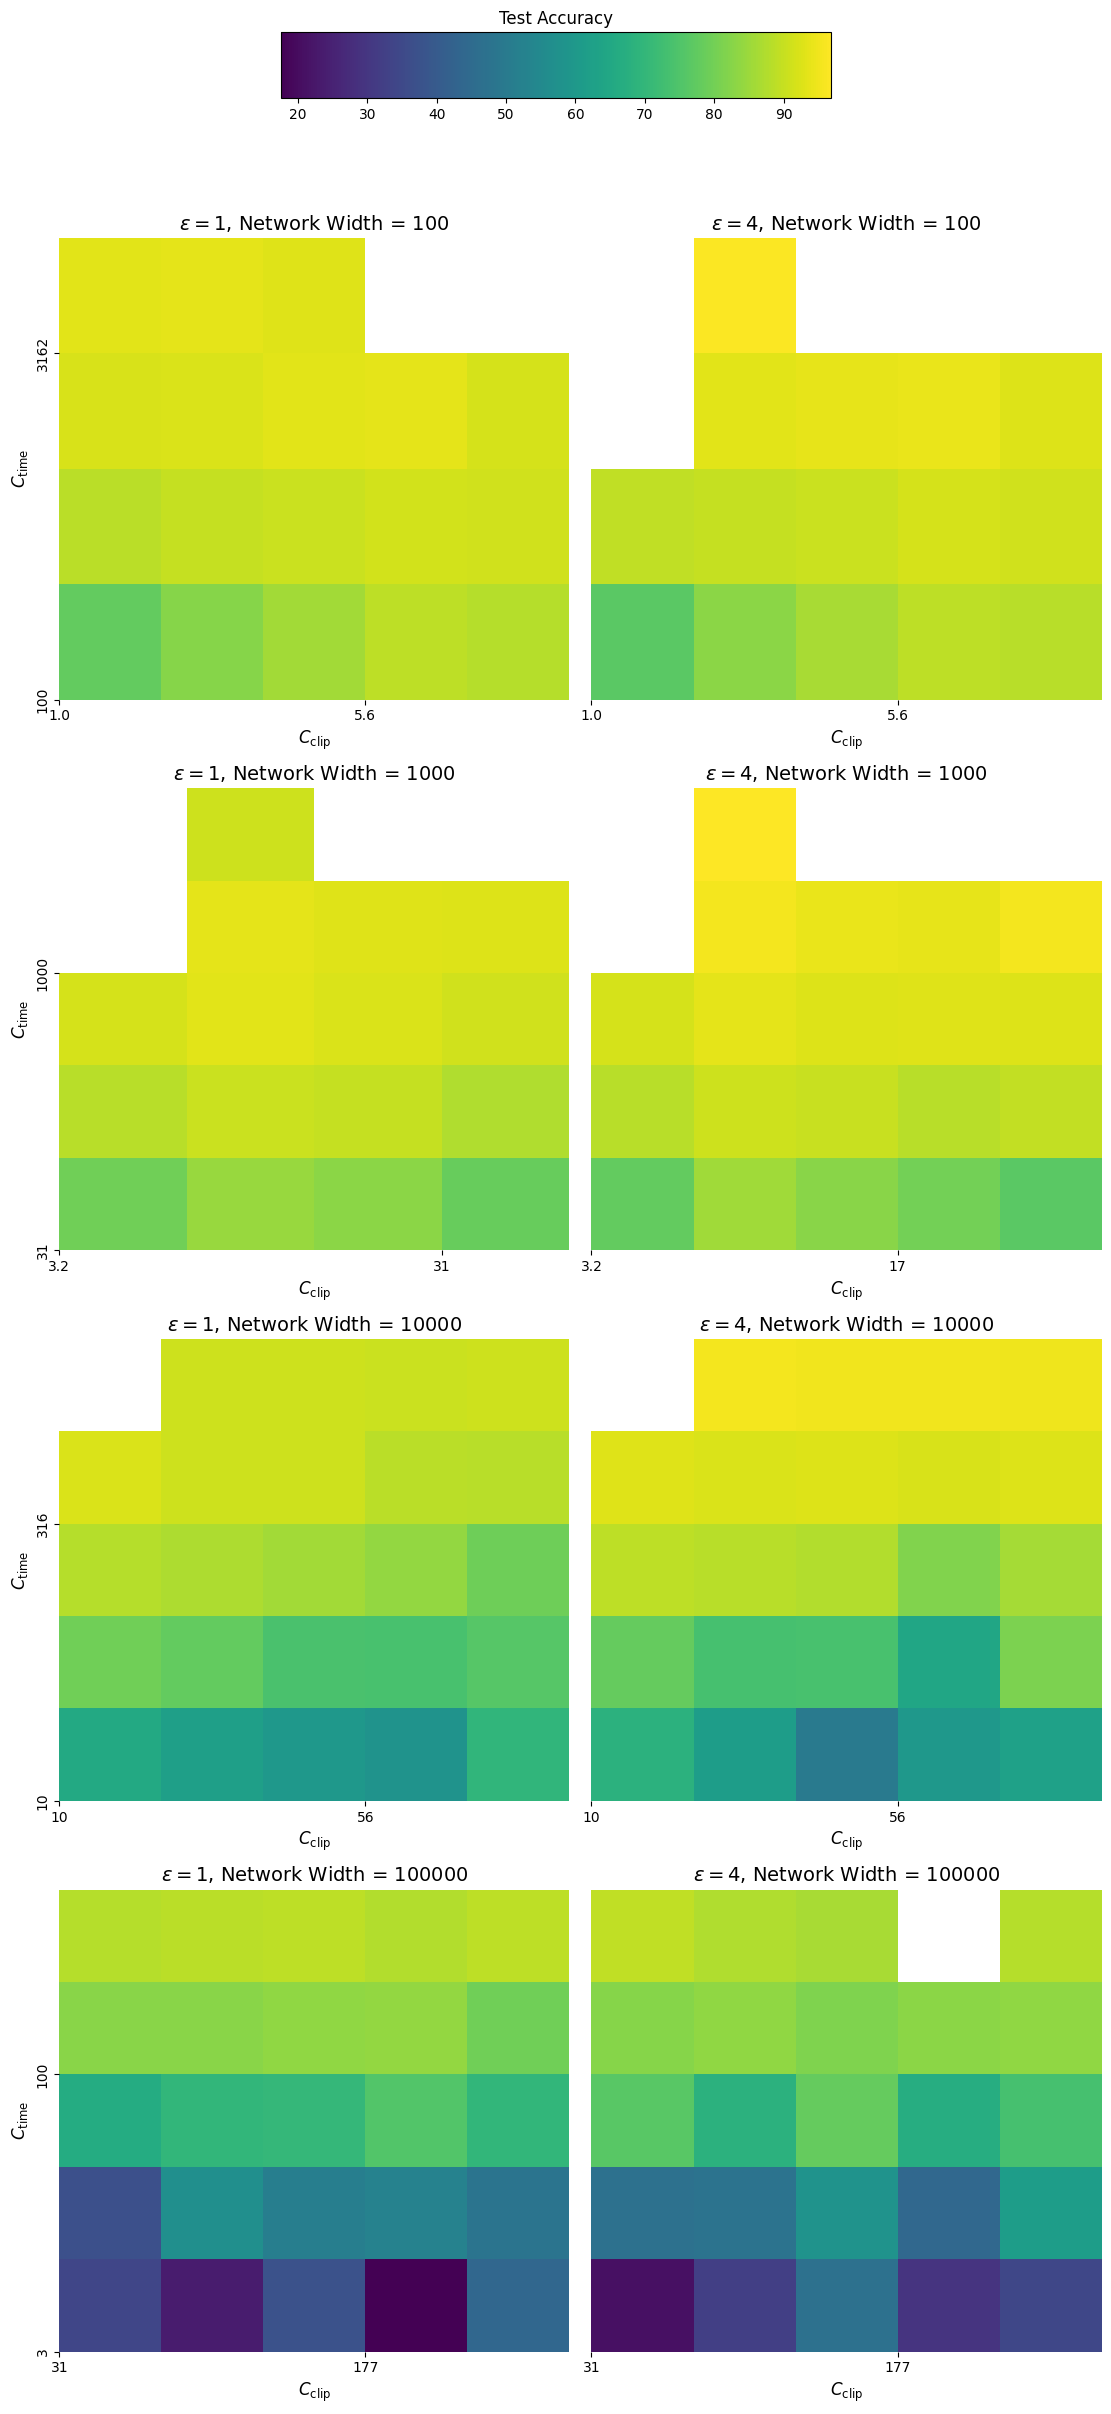

In [16]:
plot_heatmap_final_test_loss_NN(dfC1, epsilons=[1, 4], network_widths=[100, 1000, 10000, 100000])

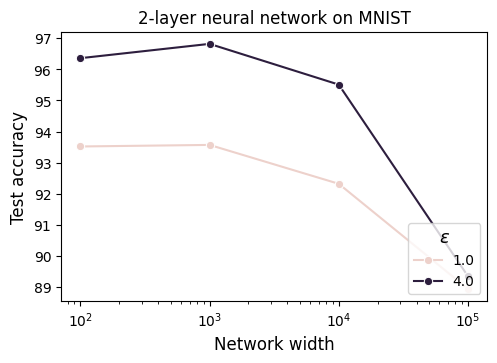

In [17]:
def plot_max_test_accuracy_by_width(df):
    # Group by 'epsilon' and 'network_width', and get the max test accuracy for each combination
    df_max_test_accuracy = df.groupby(['eps', 'network_width'], as_index=False).agg({'test_accuracy': 'max'})

    # Set the seaborn palette to viridis
    

    # Create the lineplot
    plt.figure(figsize=(5.5, 3.5))
    ax = sns.lineplot(data=df_max_test_accuracy, x='network_width', y='test_accuracy', hue='eps', marker='o')
    
    # Set x-axis to log scale
    ax.set_xscale('log')
    
    # Set plot labels and title
    plt.xlabel('Network width', fontsize=12)
    plt.ylabel('Test accuracy', fontsize=12)
    plt.title('2-layer neural network on MNIST', fontsize=12)
    
    # Update legend to use LaTeX for epsilon and place it in the bottom-right corner
    plt.legend(title=r'$\epsilon$', fontsize=10, title_fontsize='13', loc='lower right')
    
    # Save the plot as a PDF file
    plt.savefig('max_test_accuracy_by_width.pdf', format='pdf', bbox_inches='tight')

    # Show the plot
    plt.show()

# Example usage:
plot_max_test_accuracy_by_width(dfC1)

In [304]:
df_max_test_accuracy = df.groupby(['eps', 'network_width'], as_index=False).agg({'test_accuracy': 'max'})

In [305]:
df_max_test_accuracy

,eps,network_width,test_accuracy
0,1.0,100,94.27
1,1.0,1000,94.40
2,1.0,10000,92.32
3,1.0,100000,85.95
4,4.0,100,95.45
5,4.0,1000,97.14
6,4.0,10000,96.45
7,4.0,100000,88.56


In [13]:
import numpy as np

# For time

In [134]:
directories = ['./synthetic/12_09_scaling_time_new'] #, './synthetic/12_09_scaling_time_new_big_ps_small_eta'] # ['./synthetic/08_09_scaling_time_2_small_eta', './synthetic/03_09_scaling_time', './synthetic/10_09_scaling_time']

In [135]:
def load_json_files_to_dataframe(directories):
    all_data = []

    # Loop through each directory in the list
    for directory in directories:
        for filename in os.listdir(directory):
            if filename.endswith(".json"):
                filepath = os.path.join(directory, filename)
                with open(filepath, 'r') as file:
                    data = json.load(file)
                    
                    # Extract common data
                    row = {
                        'd': data['d'],
                        'n': data['n'],
                        'p': data['p'],
                        'final_test_loss': data['final_test_loss'],
                        'target': data['target'],
                        'eps': data['eps'],
                        'eta': data['eta'],
                        'T': data['T'],
                        'C_clip': data['C_clip'],
                        'C_time': data['C_time']
                    }
                    all_data.append(row)
    
    # Create DataFrame
    df = pd.DataFrame(all_data)
    
    return df

df_private = load_json_files_to_dataframe(directories)

In [136]:
df_private

,d,n,p,final_test_loss,target,eps,eta,T,C_clip,C_time
0,100,2000,695,0.536047,sign,4,0.001,2199,0.5,15.283067
1,100,2000,20691,0.586348,sign,4,0.001,88,0.5,18.329807
2,100,2000,23,0.987361,sign,4,0.001,15520,0.5,3.569699
3,100,2000,20691,0.414208,sign,4,0.001,24,0.5,5.134833
4,100,2000,15,0.974454,sign,4,0.001,49241,0.5,7.386200
...,...,...,...,...,...,...,...,...,...,...
3889,100,2000,297,0.568211,sign,4,0.001,1441,0.5,4.281332
3890,100,2000,194,0.564441,sign,4,0.001,1840,0.5,3.569699
3891,100,2000,454,0.504882,sign,4,0.001,786,0.5,3.569699
3892,100,2000,454,0.470328,sign,4,0.001,1131,0.5,5.134833


In [137]:
df_private = df_private[df_private['p'] >= 50].copy()

In [138]:
stats_df = df_private.groupby(['p', 'T'])['final_test_loss'].agg(['mean', 'std']).reset_index()
best_T_per_p = stats_df.loc[stats_df.groupby('p')['mean'].idxmin()]
df_private_best = pd.merge(df_private, best_T_per_p[['p', 'T']], on=['p', 'T'])
df_private_best

,d,n,p,final_test_loss,target,eps,eta,T,C_clip,C_time
0,100,2000,20691,0.414208,sign,4,0.001,24,0.5,5.134833
1,100,2000,13538,0.447202,sign,4,0.001,31,0.5,4.281332
2,100,2000,54,0.775598,sign,4,0.001,16404,0.5,8.858668
3,100,2000,3792,0.440464,sign,4,0.001,135,0.5,5.134833
4,100,2000,3792,0.439131,sign,4,0.001,135,0.5,5.134833
...,...,...,...,...,...,...,...,...,...,...
155,100,2000,3792,0.423361,sign,4,0.001,135,0.5,5.134833
156,100,2000,695,0.440437,sign,4,0.001,1062,0.5,7.386200
157,100,2000,20691,0.460832,sign,4,0.001,24,0.5,5.134833
158,100,2000,13538,0.440536,sign,4,0.001,31,0.5,4.281332


In [139]:
# df_private['tau'] = df_private['T'] * df_private['eta']

In [140]:
def load_and_plot_json_data(directories):
    data = []
    # Loop through each directory in the list
    for folder_path in directories:
        for file_name in os.listdir(folder_path):
            if file_name.endswith('.json'):
                file_path = os.path.join(folder_path, file_name)
                with open(file_path, 'r') as file:
                    json_data = json.load(file)
                    # Append the relevant data to the list
                    data.append({
                        'p': json_data['p'],
                        'final_test_loss': json_data['test_loss_pseudo']
                    })
    
    # Create a DataFrame
    df = pd.DataFrame(data)
    return df

# Example usage with multiple directories
directories = ['./synthetic/12_09_original_new', './synthetic/12_09_original_new_big_ps'] # ['./synthetic/08_09_original', './synthetic/10_09_original']
df_star = load_and_plot_json_data(directories)

df_star

,p,final_test_loss
0,54,0.751198
1,13538,0.435964
2,2481,1.996970
3,20691,0.415839
4,83,0.563649
...,...,...
245,172504,0.387266
246,263633,0.390992
247,48328,0.406995
248,48328,0.400444


In [141]:
df_star = df_star[df_star['p'] >= 50].copy()

In [142]:
# def plot_random_final_test_loss(df):
#     # Create a new column for the logarithm of p
#     df['log_p'] = np.log10(df['p'])

#     plt.figure(figsize=(10, 6))
#     ax = sns.lineplot(data=df, x='T', y='final_test_loss', hue='log_p') # , marker='o')

#     # Set both axes to log scale
#     ax.set_xscale('log')
#     ax.set_yscale('log')

#     # Set plot labels
#     plt.xlabel('T (log scale)', fontsize=12)
#     plt.ylabel('Final Test Loss (log scale)', fontsize=12)
#     plt.title('Final Test Loss vs. T for All log(p) Values', fontsize=14)

#     # Show the plot
#     plt.show()

# # Example usage:
# plot_random_final_test_loss(df_private)

In [143]:
# def plot_random_final_test_loss(df):
#     # Create a new column for the logarithm of p
#     df['log_p'] = np.log10(df['p'])

#     # Set up the figure with one subplot (for now)
#     fig, ax = plt.subplots(1, 2, figsize=(20, 6))  # This creates 1 row and 2 columns of subplots
    
#     # Plotting Final Test Loss vs. T for all log(p) values in the second subplot (leaving the first blank for future use)
#     sns.lineplot(data=df, x='T', y='final_test_loss', hue='log_p', ax=ax[1])  # ax[1] refers to the second subplot

#     # Set both axes to log scale
#     ax[1].set_xscale('log')
#     ax[1].set_yscale('log')

#     # Set plot labels and title
#     ax[1].set_xlabel('T (log scale)', fontsize=12)
#     ax[1].set_ylabel('Final Test Loss (log scale)', fontsize=12)
#     ax[1].set_title('Final Test Loss vs. T for All log(p) Values', fontsize=14)

#     # Setting the first subplot as invisible or unused (you could potentially use it later)
#     ax[0].set_visible(False)  # This hides the first subplot

#     plt.tight_layout()
#     plt.show()


# plot_random_final_test_loss(df_private)

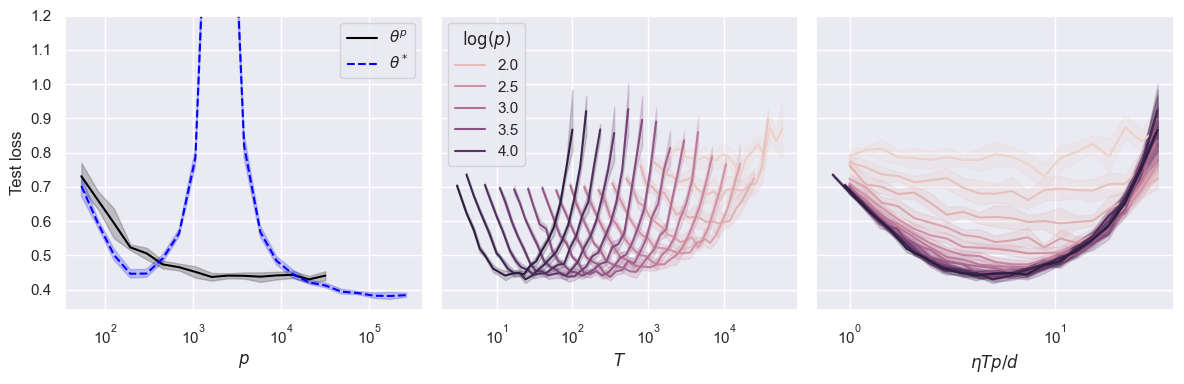

In [145]:
def integrated_plotting_function(df_private, df_private_best, df_star):
    sns.set_theme(style="darkgrid")
    
    df_private_best['source'] = r'$\theta^p$'  # Best test loss
    df_star['source'] = r'$\theta^*$'  # Pseudo test loss
    combined_df = pd.concat([df_private_best, df_star], ignore_index=True)
    combined_df.sort_values(by='p', inplace=True)
    
    # Set up the figure with three subplots
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))

    # First subplot for combined data
    sns.lineplot(data=combined_df[combined_df['source'] == r'$\theta^p$'], x='p', y='final_test_loss', ax=ax[0], linestyle='-', color='black', label=r'$\theta^p$')
    sns.lineplot(data=combined_df[combined_df['source'] == r'$\theta^*$'], x='p', y='final_test_loss', ax=ax[0], linestyle='--', color='blue', label=r'$\theta^*$')
    ax[0].set_xscale('log')
    ax[0].set_ylim(0.34, 1.2)
    ax[0].set_xlabel(r'$p$', fontsize=12)
    ax[0].set_ylabel('Test loss', fontsize=12)
    ax[0].get_legend()

    # Second subplot for random final test loss
    df_private[r'$\log(p)$'] = np.log10(df_private['p'])
    sns.lineplot(data=df_private, x='T', y='final_test_loss', hue=r'$\log(p)$', ax=ax[1])
    ax[1].set_xscale('log')
    ax[1].set_ylim(0.34, 1.2)
    ax[1].set_xlabel(r'$T$', fontsize=12)
    ax[1].set_ylabel('')
    ax[1].set_yticklabels([])

    # Third subplot for test loss vs. T*p
    df_private['T_p'] = df_private['T'] * df_private['p'] * df_private['eta'] / df_private['d']
    sns.lineplot(data=df_private, x='T_p', y='final_test_loss', hue=r'$\log(p)$', ax=ax[2])
    ax[2].set_xscale('log')
    ax[2].set_ylim(0.34, 1.2)
    ax[2].set_xlabel(r'$\eta T p / d$', fontsize=12)
    ax[2].set_ylabel('')
    ax[2].set_yticklabels([])
    ax[2].get_legend().remove()

    plt.tight_layout()
    plt.show()

    fig.savefig('RF_first_plot.pdf', format='pdf')
    
integrated_plotting_function(df_private, df_private_best, df_star)

In [65]:
# def plot_combined_data(df1, df2):
#     # Ensure the p column is of integer type for correct plotting
#     df1['p'] = df1['p'].astype(int)
#     df2['p'] = df2['p'].astype(int)
    
#     # Rename columns to unify them for plotting
#     df1.rename(columns={'best_final_test_loss': 'loss'}, inplace=True)
#     df2.rename(columns={'pseudo_test_loss': 'loss'}, inplace=True)
    
#     # Add a source column to distinguish the dataframes
#     df1['source'] = 'Final Test Loss'
#     df2['source'] = 'Pseudo Test Loss'
    
#     # Combine the dataframes
#     combined_df = pd.concat([df1, df2], ignore_index=True)
    
#     # Sort the dataframe by p for plotting
#     combined_df.sort_values(by='p', inplace=True)
    
#     # Set the seaborn theme to darkgrid
#     sns.set_theme(style="darkgrid")
    
#     # Create the lineplot
#     plt.figure(figsize=(10, 6))
#     sns.lineplot(data=combined_df, x='p', y='loss', hue='source')
    
#     # Set the x-axis to a logarithmic scale
#     plt.xscale('log')
    
#     # Set the y-axis upper bound
#     plt.ylim(0, 1.5)
    
#     # Set plot labels and title
#     plt.xlabel('p (log scale)', fontsize=12)
#     plt.ylabel('Loss', fontsize=12)
#     plt.title('Comparison of Loss Metrics', fontsize=14)
    
#     # Show the plot
#     plt.show()

# # Assuming df_private_best and df_star are your dataframes
# plot_combined_data(df_private_best, df_star)

In [34]:
# def plot_heatmap_by_p_and_T(df, d, n, eps, quantity='final_test_loss'):
#     # Filter the DataFrame based on the fixed parameters
#     df_filtered = df[
#         (df['d'] == d) & 
#         (df['n'] == n) & 
#         (df['eps'] == eps)
#     ]

#     # Group by 'p' and 'T' and calculate the mean of the relevant columns
#     df_grouped = df_filtered.groupby(['p', 'T']).agg({
#         'final_test_loss': 'mean'
#     }).reset_index()

#     # Validate the 'quantity' input and apply the minimum function
#     if quantity not in df_grouped.columns:
#         raise ValueError(f"Invalid quantity '{quantity}'. Must be one of 'final_train_loss', 'final_test_loss', 'train_loss_star', 'test_loss_star'.")
    
#     df_grouped[f'{quantity}_crop'] = df_grouped[quantity].apply(lambda x: min(x, 2))
#     df_grouped[f'log_{quantity}'] = np.log10(df_grouped[f'{quantity}_crop'])

#     # Pivot the DataFrame to get T and p on the axes
#     heatmap_data = df_grouped.pivot(index='T', columns='p', values=f'log_{quantity}')

#     if heatmap_data.empty:
#         raise ValueError(f"No data available to plot for the given parameters: d={d}, n={n}, eps={eps}, quantity={quantity}")

#     # Plot the heatmap
#     plt.figure(figsize=(10, 8))
#     sns.heatmap(heatmap_data, annot=False, cmap="viridis", cbar=True)
#     plt.title(f'Log {quantity.replace("_", " ").title()} Heatmap (d={d}, n={n}, eps={eps})')
#     plt.xlabel('p')
#     plt.ylabel('T')
#     plt.gca().invert_yaxis()  # Invert the y-axis
#     plt.show()

# # Example usage:
# plot_heatmap_by_p_and_T(df, d=100, n=2000, eps=4, quantity='final_test_loss')


In [35]:
# def plot_random_final_test_loss(df):
#     # Create a new column for the logarithm of p
#     df['log_p'] = np.log10(df['p'])

#     plt.figure(figsize=(10, 6))
#     ax = sns.lineplot(data=df, x='T', y='final_test_loss', hue='log_p', marker='o')

#     # Set both axes to log scale
#     ax.set_xscale('log')
#     ax.set_yscale('log')

#     # Set plot labels
#     plt.xlabel('T (log scale)', fontsize=12)
#     plt.ylabel('Final Test Loss (log scale)', fontsize=12)
#     plt.title('Final Test Loss vs. T for All log(p) Values', fontsize=14)

#     # Show the plot
#     plt.show()

# # Example usage:
# plot_random_final_test_loss(df)


In [36]:
# df_mean = df.groupby(['p', 'T'], as_index=False).agg({'final_test_loss': 'mean'})
# df_mean

In [88]:
# plot_random_final_test_loss(df_mean)

In [89]:
# def plot_min_final_test_loss(df):
#     # Set the seaborn theme to darkgrid
#     sns.set_theme(style="darkgrid")

#     # Step 1: Compute mean and std of the loss for each (p, T)
#     stats_df = df.groupby(['p', 'T'])['final_test_loss'].agg(['mean', 'std']).reset_index()

#     # Step 2: Identify the best T for each p with the lowest mean loss
#     best_T_per_p = stats_df.loc[stats_df.groupby('p')['mean'].idxmin()]

#     # Step 3: Merge the best T back into the original DataFrame to filter only relevant entries
#     filtered_df = pd.merge(df, best_T_per_p[['p', 'T']], on=['p', 'T'])

#     # Step 4: Create the lineplot
#     plt.figure(figsize=(10, 6))
#     sns.lineplot(data=filtered_df, x='p', y='final_test_loss',
#                  estimator='mean', errorbar='sd') #, marker='o')

#     # Set the x-axis to a logarithmic scale
#     plt.xscale('log')

#     # Set plot labels and title
#     plt.xlabel('p (log scale)', fontsize=12)
#     plt.ylabel('Minimal Final Test Loss', fontsize=12)
#     plt.title('Minimal Final Test Loss vs p for Best T', fontsize=14)

#     # Show the plot
#     plt.show()

# # Example usage, assuming df is your DataFrame
# plot_min_final_test_loss(df)


In [424]:
# def plot_T_for_lowest_final_test_loss(df):
#     # Group by 'p' and find the row with the lowest 'final_test_loss' for each value of 'p'
#     df_min_loss = df.loc[df.groupby('p')['final_test_loss'].idxmin()]

#     # Create a lineplot with 'p' on the x-axis and the corresponding 'T' on the y-axis
#     plt.figure(figsize=(10, 6))
#     sns.lineplot(data=df_min_loss, x='p', y='T', marker='o')

#     # Set plot labels and title
#     plt.xlabel('p', fontsize=12)
#     plt.ylabel('T corresponding to lowest Final Test Loss', fontsize=12)
#     plt.title('T vs. p for Lowest Final Test Loss', fontsize=14)

#     # Show the plot
#     plt.show()

# # Example usage:
# plot_T_for_lowest_final_test_loss(df_mean)

In [425]:
# def plot_one_over_T_for_lowest_final_test_loss(df):
#     # Group by 'p' and find the row with the lowest 'final_test_loss' for each value of 'p'
#     df_min_loss = df.loc[df.groupby('p')['final_test_loss'].idxmin()]

#     # Create a lineplot with 'p' on the x-axis and 1/T on the y-axis
#     plt.figure(figsize=(10, 6))
#     sns.lineplot(data=df_min_loss, x='p', y=1/df_min_loss['T'], marker='o')

#     # Set plot labels and title
#     plt.xlabel('p', fontsize=12)
#     plt.ylabel('1/T corresponding to Lowest Final Test Loss', fontsize=12)
#     plt.title('1/T vs. p for Lowest Final Test Loss', fontsize=14)

#     # Show the plot
#     plt.show()

# # Example usage:
# plot_one_over_T_for_lowest_final_test_loss(df_mean)


In [156]:
import os
import json
import pandas as pd
import numpy as np

def load_data_from_json(directories):
    data_rows = []
    # Iterate over each directory in the list
    for folder_path in directories:
        for file_name in os.listdir(folder_path):
            if file_name.endswith('.json'):
                file_path = os.path.join(folder_path, file_name)
                with open(file_path, 'r') as file:
                    data = json.load(file)
                data_rows.append(data)
    # Create a DataFrame from all collected data
    df = pd.DataFrame(data_rows)
    return df

# Usage example with multiple directories
directories = ['./NN/13_09_grid'] # ['./NN/11_09_not_so_grid', './NN/11_09_not_so_grid_otherC2',  './NN/11_09_not_so_grid_otherCs']  # List multiple directories here
df = load_data_from_json(directories)

In [157]:
df

,width,lr,batch_size,eps,clip_value_1,clip_value_2,T,test_accuracies,train_losses,clipping_mode
0,400,1,2000,1,1.274275,None,46,"[0.15489999949932098, 0.2807999849319458, 0.40...","[2.6273910999298096, 2.245394468307495, 1.9438...",global
1,1000,1,800,4,11.288379,None,46,"[0.4129999876022339, 0.5899999737739563, 0.618...","[2.348801612854004, 2.934569835662842, 2.10973...",global
2,400,1,2000,1,1.623777,None,10,"[0.18940000236034393, 0.3682999908924103, 0.47...","[2.495579242706299, 2.0499179363250732, 1.7227...",global
3,100,1,8000,4,61.584821,None,46,"[0.6421999931335449, 0.6107000112533569, 0.598...","[1.344960331916809, 1.3360445499420166, 2.3194...",global
4,100,1,8000,1,100.000000,None,129,"[0.14829999208450317, 0.2483999878168106, 0.28...","[35.0273323059082, 106.8372573852539, 158.4149...",global
...,...,...,...,...,...,...,...,...,...,...
1684,100,1,8000,1,2.069138,None,46,"[0.23169998824596405, 0.33629998564720154, 0.4...","[2.4668893814086914, 2.072409152984619, 1.7693...",global
1685,100,1,8000,1,14.384499,None,27,"[0.5751999616622925, 0.6865999698638916, 0.727...","[1.317465901374817, 1.0700103044509888, 0.9056...",global
1686,200,1,4000,4,14.384499,None,10,"[0.6575999855995178, 0.7997999787330627, 0.826...","[1.169089436531067, 0.7505946755409241, 0.6101...",global
1687,40,1,20000,1,78.475997,None,27,"[0.3384999930858612, 0.4106999933719635, 0.332...","[3.08453631401062, 6.388020992279053, 9.832002...",global


In [158]:
def process_dataframe(df):
    # Keeping specific columns and the last value of the test accuracy
    df['last_test_accuracy'] = df['test_accuracies'].apply(lambda x: x[-1])
    df['log_clip_value_2'] = np.log10(df['clip_value_1'])
    # df['log_clip_value_2'] = np.log10(df['clip_value_2'])
    processed_df = df[['width', 'log_clip_value_2', 'T', 'eps', 'last_test_accuracy']]
    return processed_df

processed_df = process_dataframe(df)
processed_df

,width,log_clip_value_2,T,eps,last_test_accuracy
0,400,0.105263,46,1,0.8736
1,1000,1.052632,46,4,0.9196
2,400,0.210526,10,1,0.7528
3,100,1.789474,46,4,0.8266
4,100,2.000000,129,1,0.7442
...,...,...,...,...,...
1684,100,0.315789,46,1,0.8768
1685,100,1.157895,27,1,0.8504
1686,200,1.157895,10,4,0.8954
1687,40,1.894737,27,1,0.6686


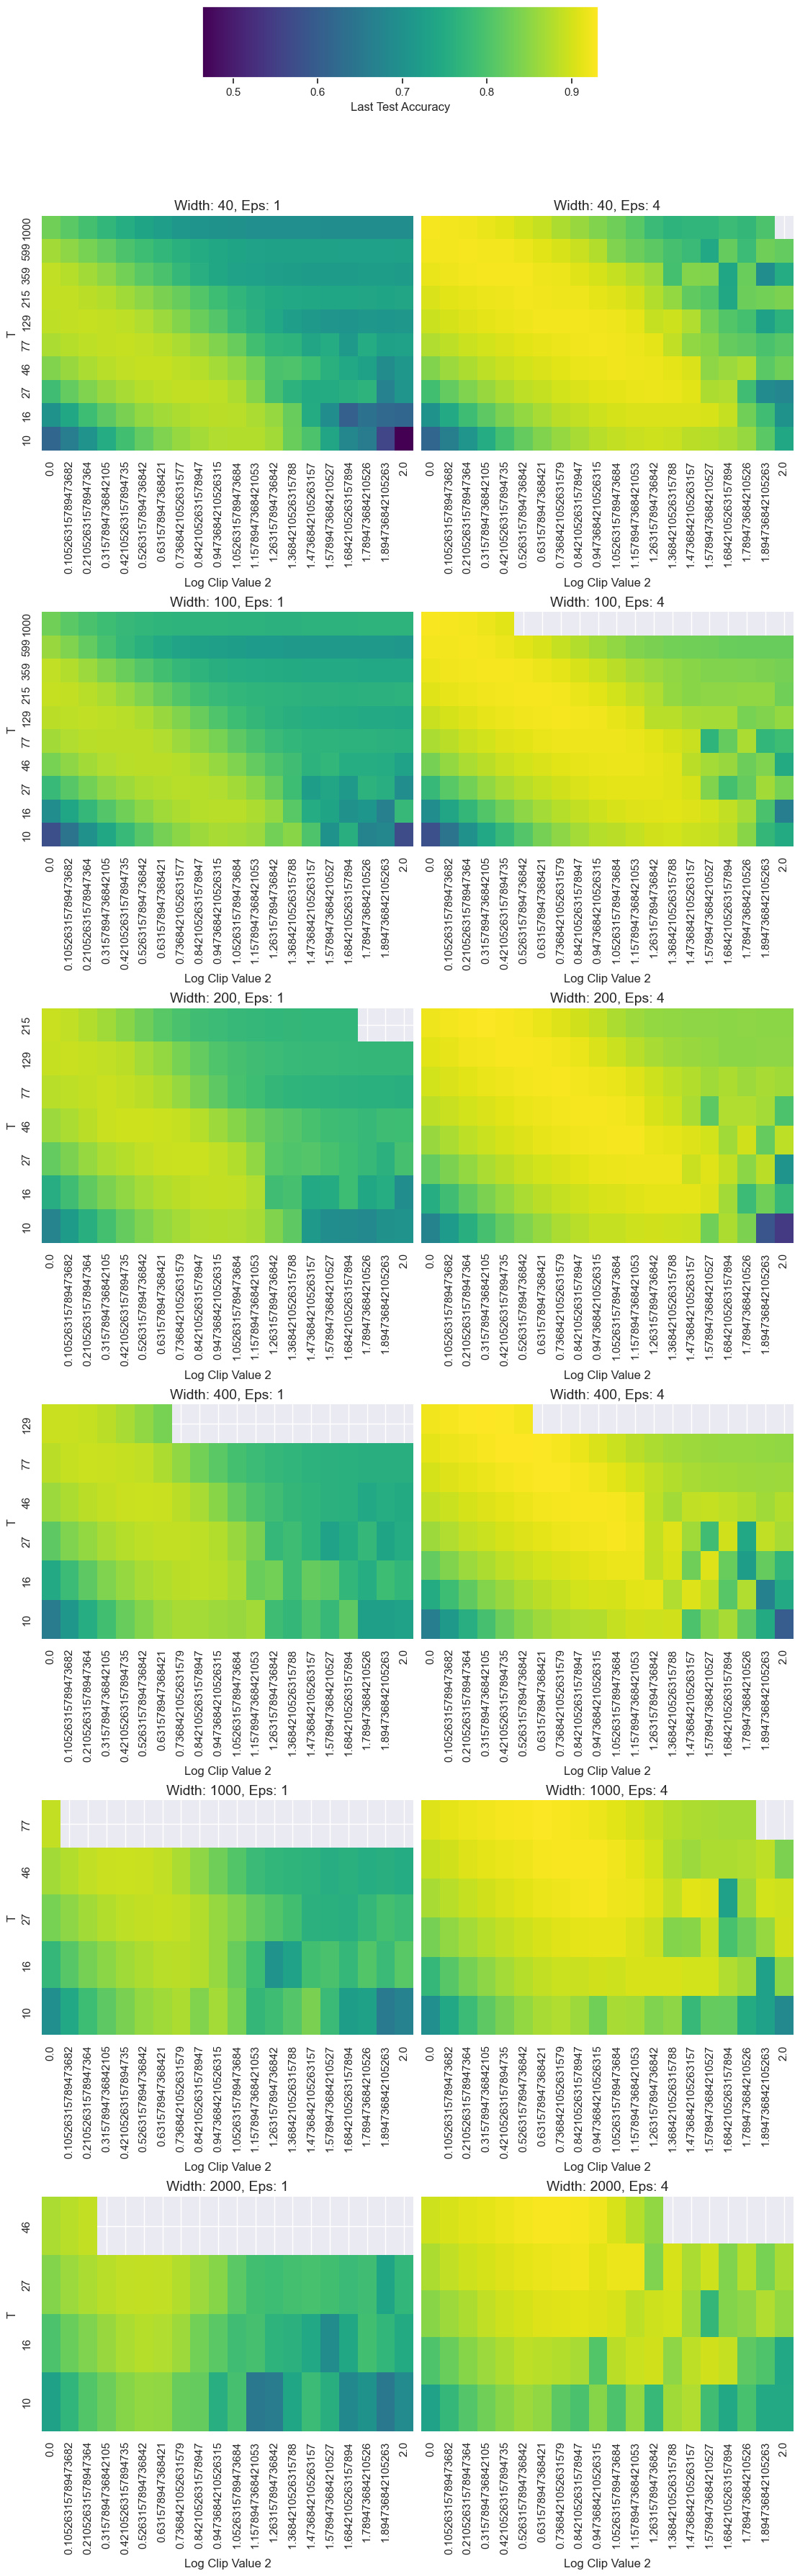

In [159]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def plot_heatmap_final_test_accuracy(df, clip_value_1, network_widths, epsilons, training_mode):
    # Filter the DataFrame by a fixed clip_value_1
    # df = df[df['log_clip_value_1'] == np.log10(clip_value_1)]
    # df = df[df['training_mode'] == training_mode]

    # Create a figure with subplots for each network_width (rows) and epsilon (columns)
    fig, axes = plt.subplots(len(network_widths), len(epsilons), figsize=(11, 5.5 * len(network_widths)), constrained_layout=True)
    vmin, vmax = df['last_test_accuracy'].min(), df['last_test_accuracy'].max()  # Min and max values for consistent color mapping

    for i, width in enumerate(network_widths):
        for j, eps in enumerate(epsilons):
            ax = axes[i][j] if len(network_widths) > 1 else axes[j]
            df_filtered = df[(df['eps'] == eps) & (df['width'] == width)]

            # Create a DataFrame for the heatmap
            df_collapsed = df_filtered.groupby(['T', 'log_clip_value_2'], as_index=False).agg({'last_test_accuracy': 'mean'})
            heatmap_data = df_collapsed.pivot(index='T', columns='log_clip_value_2', values='last_test_accuracy')
            # Plot the heatmap on the current axis
            sns.heatmap(heatmap_data, ax=ax, cmap="viridis", annot=False, cbar=False, vmin=vmin, vmax=vmax)
            ax.set_title(f'Width: {width}, Eps: {eps}', fontsize=14)
            ax.set_xlabel('Log Clip Value 2', fontsize=12)

            # Customize y-axis for the first column of plots (leftmost column)
            if j == 0:
                ax.set_ylabel('T', fontsize=12)
            else:
                ax.set_ylabel('')
                ax.set_yticks([])

            # Invert y-axis for correct heatmap representation
            ax.invert_yaxis()

    # Adjust the colorbar to be higher and positioned horizontally
    cbar_ax = fig.add_axes([0.25, 1.05, 0.5, 0.03])  # Adjust position to move higher above the plots
    cbar = plt.colorbar(axes[0, 0].collections[0], cax=cbar_ax, orientation='horizontal')
    cbar.set_label('Last Test Accuracy', fontsize=12)

    plt.show()

# Example usage parameters
clip_value_1_fixed = 10  # Assuming you want to fix clip_value_1 at 10
network_widths = [40, 100, 200, 400, 1000, 2000]  # Add other widths as needed
epsilons = [1, 4]  # Add other eps values as needed
training_mode = 'full'

plot_heatmap_final_test_accuracy(processed_df, clip_value_1_fixed, network_widths, epsilons, training_mode)

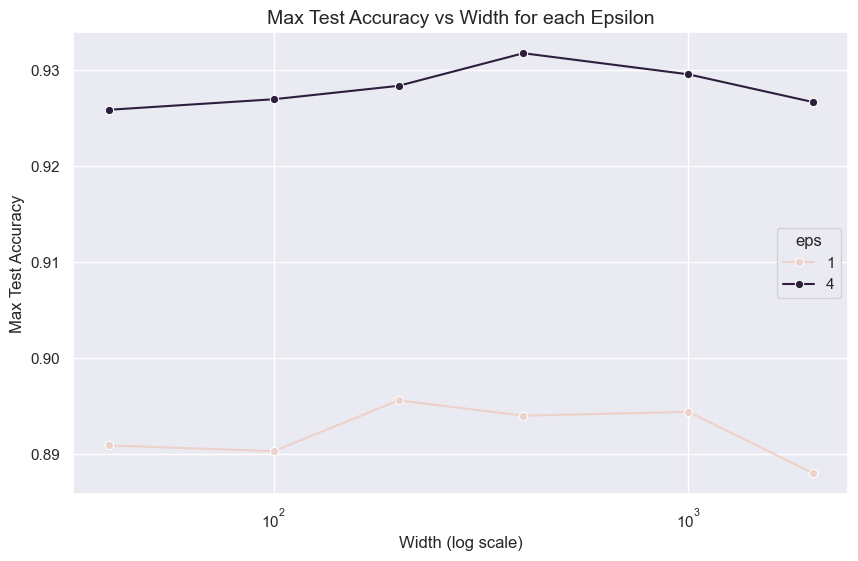

In [160]:
def plot_max_accuracy_by_width_and_epsilon(df, clip_value_1_fixed, training_mode):
    # Filter the DataFrame based on the fixed clip_value_1
    # df = df[df['log_clip_value_1'] == np.log10(clip_value_1_fixed)]
    # df = df[df['training_mode'] == training_mode]


    # Compute the maximum last_test_accuracy for each combination of width and epsilon
    max_accuracy_df = df.groupby(['width', 'eps'])['last_test_accuracy'].max().reset_index()

    # Set the seaborn theme to darkgrid
    sns.set_theme(style="darkgrid")

    # Create the lineplot
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=max_accuracy_df, x='width', y='last_test_accuracy', hue='eps', marker='o')

    # Set the x-axis to a logarithmic scale
    plt.xscale('log')

    # Set plot labels and title
    plt.xlabel('Width (log scale)', fontsize=12)
    plt.ylabel('Max Test Accuracy', fontsize=12)
    plt.title('Max Test Accuracy vs Width for each Epsilon', fontsize=14)

    # Show the plot
    plt.show()

# Example usage, assuming df is your DataFrame
clip_value_1_fixed = 1
# training_mode = 'full'
plot_max_accuracy_by_width_and_epsilon(processed_df, clip_value_1_fixed, training_mode)